In [ ]:
!pip install -q wordcloud nltk tensorflow pandas numpy matplotlib seaborn scikit-learn scipy

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Dropout, Input, LSTM, GRU,
                                   Embedding, Concatenate, Subtract,
                                   Multiply, Lambda)
from tensorflow.keras.optimizers import Adam
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, roc_curve, auc)

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Section 1: EDA (Exploratory Data Analysis)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

def perform_eda(train_df):
    # Basic information about the dataset
    print("\nTraining Dataset Info:")
    print(train_df.info())

    print("\nMissing values:")
    print(train_df.isnull().sum())

    # Distribution of duplicate vs non-duplicate questions
    plt.figure(figsize=(8, 6))
    sns.countplot(x='is_duplicate', data=train_df)
    plt.title('Distribution of Duplicate vs Non-Duplicate Questions')
    plt.show()

    # Question length analysis
    train_df['q1_len'] = train_df['question1'].str.len()
    train_df['q2_len'] = train_df['question2'].str.len()

    # Length distributions
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(train_df['q1_len'], bins=50, color='blue', alpha=0.5)
    plt.title('Question 1 Length Distribution')

    plt.subplot(1, 2, 2)
    sns.histplot(train_df['q2_len'], bins=50, color='blue', alpha=0.5)
    plt.title('Question 2 Length Distribution')
    plt.tight_layout()
    plt.show()

    # Word clouds
    def create_wordcloud(text_series, title):
        text = ' '.join(text_series.dropna().astype(str))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title)
        plt.show()

    create_wordcloud(train_df['question1'], 'Word Cloud - Question 1')
    create_wordcloud(train_df['question2'], 'Word Cloud - Question 2')

    # Basic statistics
    print("\nBasic statistics of question lengths:")
    print(train_df[['q1_len', 'q2_len']].describe())

    return train_df

In [ ]:
def build_baseline_models(input_dim):
    """Build and return memory-efficient baseline models"""

    print("Creating baseline models...")
    # Use SGDClassifier instead of LogisticRegression for memory efficiency
    lr_model = SGDClassifier(
        loss='log_loss',  # This makes it equivalent to logistic regression
        max_iter=100,
        tol=1e-3,
        n_jobs=-1,  # Use all available cores
        random_state=42
    )

    # Use SGDClassifier with hinge loss instead of LinearSVC
    svm_model = SGDClassifier(
        loss='hinge',  # This makes it equivalent to LinearSVC
        max_iter=100,
        tol=1e-3,
        n_jobs=-1,
        random_state=42
    )

    return lr_model, svm_model

def build_basic_ann(input_dim):
    """Build and return a basic feedforward neural network"""

    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    return model

def build_lstm_model(max_sequence_length, vocab_size, embedding_dim=100):
    """Build and return an LSTM-based model with correct input shape"""
    model = Sequential([
        # Changed input shape to match the data dimensions
        Input(shape=(max_sequence_length, 1)),  # Changed to 1 feature dimension
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

def build_gru_model(max_sequence_length, vocab_size, embedding_dim=100):
    """Build and return a GRU-based model with correct input shape"""
    model = Sequential([
        # Changed input shape to match the data dimensions
        Input(shape=(max_sequence_length, 1)),  # Changed to 1 feature dimension
        GRU(64, return_sequences=True),
        GRU(32),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

def build_siamese_network(max_sequence_length, vocab_size, embedding_dim=100):
    """Build and return a Siamese network with correct input shape"""
    def create_base_network():
        return Sequential([
            Input(shape=(max_sequence_length, 1)),  # Changed to 1 feature dimension
            LSTM(64, return_sequences=True),
            LSTM(32),
            Dense(32, activation='relu')
        ])

    base_network = create_base_network()

    input_q1 = Input(shape=(max_sequence_length, 1))
    input_q2 = Input(shape=(max_sequence_length, 1))

    processed_q1 = base_network(input_q1)
    processed_q2 = base_network(input_q2)

    subtracted = Subtract()([processed_q1, processed_q2])
    multiplied = Multiply()([processed_q1, processed_q2])
    combined = Concatenate()([subtracted, multiplied])

    dense1 = Dense(32, activation='relu')(combined)
    dropout = Dropout(0.2)(dense1)
    output = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=[input_q1, input_q2], outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [ ]:
def process_tfidf_in_batches(texts, tfidf, batch_size=1000):
    """Process TF-IDF features in batches to save memory"""
    features = []

    # Process in batches
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        batch_features = tfidf.transform(batch)
        features.append(batch_features)

    # Combine all batches
    return hstack(features)

In [ ]:
def preprocess_data_for_all_models(max_sequence_length=100, max_vocab_size=10000, sample_size=100000):
    """Preprocess data with consistent sample sizes"""

    print("Loading training data...")
    # Load a sample of the data
    train_df = pd.read_csv('/content/drive/MyDrive/train.csv', nrows=sample_size)

    # Split data into train and validation sets
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")

    def clean_text(text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = ' '.join(text.split())
        return text

    print("Cleaning text...")
    for df in [train_df, val_df]:
        df['clean_q1'] = df['question1'].apply(clean_text)
        df['clean_q2'] = df['question2'].apply(clean_text)

    print("Creating TF-IDF features...")
    # Use smaller max_features for TF-IDF
    tfidf = TfidfVectorizer(max_features=5000)

    # Fit on training data only
    train_text = pd.concat([train_df['clean_q1'], train_df['clean_q2']])
    tfidf.fit(train_text)

    print("Processing training data TF-IDF...")
    train_q1_tfidf = tfidf.transform(train_df['clean_q1'])
    train_q2_tfidf = tfidf.transform(train_df['clean_q2'])

    print("Processing validation data TF-IDF...")
    val_q1_tfidf = tfidf.transform(val_df['clean_q1'])
    val_q2_tfidf = tfidf.transform(val_df['clean_q2'])

    # Combine features horizontally
    print("Combining features...")
    X_train_tfidf = hstack([train_q1_tfidf, train_q2_tfidf])
    X_val_tfidf = hstack([val_q1_tfidf, val_q2_tfidf])

    print("Creating sequence features...")
    tokenizer = Tokenizer(num_words=max_vocab_size)
    tokenizer.fit_on_texts(train_text)

    # Process sequences
    train_q1_seq = tokenizer.texts_to_sequences(train_df['clean_q1'])
    train_q2_seq = tokenizer.texts_to_sequences(train_df['clean_q2'])
    val_q1_seq = tokenizer.texts_to_sequences(val_df['clean_q1'])
    val_q2_seq = tokenizer.texts_to_sequences(val_df['clean_q2'])

    # Pad sequences
    train_q1_pad = pad_sequences(train_q1_seq, maxlen=max_sequence_length)
    train_q2_pad = pad_sequences(train_q2_seq, maxlen=max_sequence_length)
    val_q1_pad = pad_sequences(val_q1_seq, maxlen=max_sequence_length)
    val_q2_pad = pad_sequences(val_q2_seq, maxlen=max_sequence_length)

    # Get labels
    y_train = train_df['is_duplicate'].values
    y_val = val_df['is_duplicate'].values

    # Print shapes for verification
    print(f"\nShape verification:")
    print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_val_tfidf shape: {X_val_tfidf.shape}")
    print(f"y_val shape: {y_val.shape}")

    # Clear some memory
    del train_df, val_df, train_text
    import gc
    gc.collect()

    return {
        'traditional': {'X_train': X_train_tfidf, 'X_val': X_val_tfidf},
        'sequence': {'X_train_q1': train_q1_pad, 'X_train_q2': train_q2_pad,
                    'X_val_q1': val_q1_pad, 'X_val_q2': val_q2_pad},
        'labels': {'y_train': y_train, 'y_val': y_val},
        'vocab_size': len(tokenizer.word_index) + 1
    }

In [ ]:
class ModelTracker:
    """Class to store and track models for later evaluation"""
    def __init__(self):
        self.models = {}
        self.predictions = {}

    def add_model(self, name, model, predictions):
        self.models[name] = model
        self.predictions[name] = predictions

def evaluate_models(tracker, X_val, y_val):
    """Evaluate models using various metrics"""
    evaluation_results = {}

    for model_name, predictions in tracker.predictions.items():
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_val, predictions > 0.5),
            'precision': precision_score(y_val, predictions > 0.5),
            'recall': recall_score(y_val, predictions > 0.5),
            'f1': f1_score(y_val, predictions > 0.5)
        }

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_val, predictions)
        roc_auc = auc(fpr, tpr)
        metrics['roc_auc'] = roc_auc
        metrics['fpr'] = fpr
        metrics['tpr'] = tpr

        # Calculate confusion matrix
        cm = confusion_matrix(y_val, predictions > 0.5)
        metrics['confusion_matrix'] = cm

        evaluation_results[model_name] = metrics

    return evaluation_results

def plot_evaluation_results(evaluation_results):
    """Plot evaluation metrics including confusion matrices and ROC curves"""
    n_models = len(evaluation_results)

    # Plot metrics comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    metric_values = {metric: [] for metric in metrics}
    model_names = []

    for model_name, results in evaluation_results.items():
        model_names.append(model_name)
        for metric in metrics:
            if metric in results:
                metric_values[metric].append(results[metric])

    # Bar plot for metrics
    plt.figure(figsize=(15, 5))
    x = np.arange(len(model_names))
    width = 0.15

    for i, metric in enumerate(metrics):
        plt.bar(x + i*width, metric_values[metric], width, label=metric)

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width*2, model_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot confusion matrices
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    plt.figure(figsize=(15, 5*n_rows))

    for i, (model_name, results) in enumerate(evaluation_results.items()):
        plt.subplot(n_rows, n_cols, i+1)
        sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for model_name, results in evaluation_results.items():
        plt.plot(results['fpr'], results['tpr'],
                label=f'{model_name} (AUC = {results["roc_auc"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

In [ ]:
def train_and_evaluate_models(X_train, X_val, y_train, y_val, vocab_size, max_sequence_length):
    """Modified training function with correct data reshaping and cardinality"""
    tracker = ModelTracker()
    results = {}

    # Train and track traditional models
    print("\nTraining baseline models...")
    lr_model, svm_model = build_baseline_models(X_train.shape[1])

    X_train_dense = X_train.toarray()
    X_val_dense = X_val.toarray()

    # Logistic Regression
    print("Training Logistic Regression...")
    lr_model.fit(X_train_dense, y_train)
    lr_pred = lr_model.predict_proba(X_val_dense)[:, 1]
    tracker.add_model('logistic_regression', lr_model, lr_pred)

    # SVM
    print("Training SVM...")
    svm_model.fit(X_train_dense, y_train)
    svm_pred = svm_model.decision_function(X_val_dense)
    tracker.add_model('svm', svm_model, svm_pred)

    # Basic ANN
    print("\nTraining Basic ANN...")
    ann_model = build_basic_ann(X_train.shape[1])
    ann_history = ann_model.fit(
        X_train_dense, y_train,
        validation_data=(X_val_dense, y_val),
        epochs=30, batch_size=32,
        verbose=1
    )
    ann_pred = ann_model.predict(X_val_dense).flatten()
    tracker.add_model('basic_ann', ann_model, ann_pred)
    results['basic_ann'] = ann_history.history

    # Prepare sequence data with correct reshaping
    # Calculate the correct number of features per timestep
    n_samples = X_train_dense.shape[0]
    n_features = X_train_dense.shape[1] // max_sequence_length

    # Reshape the data correctly
    X_train_seq = X_train_dense.reshape(n_samples, max_sequence_length, n_features)
    X_val_seq = X_val_dense.reshape(X_val_dense.shape[0], max_sequence_length, n_features)

    print(f"Sequence data shapes:")
    print(f"X_train_seq shape: {X_train_seq.shape}")
    print(f"X_val_seq shape: {X_val_seq.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_val shape: {y_val.shape}")

    # Update LSTM model to match input shape
    def build_lstm_model_updated(input_shape):
        model = Sequential([
            Input(shape=input_shape),
            LSTM(64, return_sequences=True),
            LSTM(32),
            Dense(16, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
        return model

    # LSTM with updated input shape
    print("\nTraining LSTM model...")
    lstm_model = build_lstm_model_updated((max_sequence_length, n_features))
    lstm_history = lstm_model.fit(
        X_train_seq, y_train,
        validation_data=(X_val_seq, y_val),
        epochs=30, batch_size=32,
        verbose=1
    )
    lstm_pred = lstm_model.predict(X_val_seq).flatten()
    tracker.add_model('lstm', lstm_model, lstm_pred)
    results['lstm'] = lstm_history.history

    # Update GRU model similarly
    def build_gru_model_updated(input_shape):
        model = Sequential([
            Input(shape=input_shape),
            GRU(64, return_sequences=True),
            GRU(32),
            Dense(16, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
        return model

    # GRU with updated input shape
    print("\nTraining GRU model...")
    gru_model = build_gru_model_updated((max_sequence_length, n_features))
    gru_history = gru_model.fit(
        X_train_seq, y_train,
        validation_data=(X_val_seq, y_val),
        epochs=30, batch_size=32,
        verbose=1
    )
    gru_pred = gru_model.predict(X_val_seq).flatten()
    tracker.add_model('gru', gru_model, gru_pred)
    results['gru'] = gru_history.history

    # Update Siamese network
    def build_siamese_network_updated(input_shape):
        def create_base_network():
            return Sequential([
                Input(shape=input_shape),
                LSTM(64, return_sequences=True),
                LSTM(32),
                Dense(32, activation='relu')
            ])

        base_network = create_base_network()

        input_q1 = Input(shape=input_shape)
        input_q2 = Input(shape=input_shape)

        processed_q1 = base_network(input_q1)
        processed_q2 = base_network(input_q2)

        subtracted = Subtract()([processed_q1, processed_q2])
        multiplied = Multiply()([processed_q1, processed_q2])
        combined = Concatenate()([subtracted, multiplied])

        dense1 = Dense(32, activation='relu')(combined)
        dropout = Dropout(0.2)(dense1)
        output = Dense(1, activation='sigmoid')(dropout)

        model = Model(inputs=[input_q1, input_q2], outputs=output)

        model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
        return model

    # Split sequence data for Siamese network
    X_train_q1 = X_train_seq[:, :max_sequence_length//2, :]
    X_train_q2 = X_train_seq[:, max_sequence_length//2:, :]
    X_val_q1 = X_val_seq[:, :max_sequence_length//2, :]
    X_val_q2 = X_val_seq[:, max_sequence_length//2:, :]

    # Siamese Network with updated input shape
    print("\nTraining Siamese Network...")
    siamese_model = build_siamese_network_updated((max_sequence_length//2, n_features))
    siamese_history = siamese_model.fit(
        [X_train_q1, X_train_q2], y_train,
        validation_data=([X_val_q1, X_val_q2], y_val),
        epochs=30, batch_size=32,
        verbose=1
    )
    siamese_pred = siamese_model.predict([X_val_q1, X_val_q2]).flatten()
    tracker.add_model('siamese', siamese_model, siamese_pred)
    results['siamese'] = siamese_history.history

    # Evaluate all models
    print("\nEvaluating models...")
    evaluation_results = evaluate_models(tracker, X_val_dense, y_val)

    # Plot evaluation results
    print("\nPlotting evaluation results...")
    plot_evaluation_results(evaluation_results)

    return results, evaluation_results, tracker

In [ ]:
def plot_training_results(results):
    """Plot training and validation metrics for all models"""

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    for model_name, metrics in results.items():
        if isinstance(metrics, dict) and 'accuracy' in metrics:
            plt.plot(metrics['accuracy'], label=f'{model_name} (train)')
            plt.plot(metrics['val_accuracy'], label=f'{model_name} (val)')
    plt.title('Model Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 1, 2)
    for model_name, metrics in results.items():
        if isinstance(metrics, dict) and 'loss' in metrics:
            plt.plot(metrics['loss'], label=f'{model_name} (train)')
            plt.plot(metrics['val_loss'], label=f'{model_name} (val)')
    plt.title('Model Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Set parameters
MAX_SEQUENCE_LENGTH = 50
MAX_VOCAB_SIZE = 10000
EMBEDDING_DIM = 100

Loading data...
Running EDA...

Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
None

Missing values:
id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


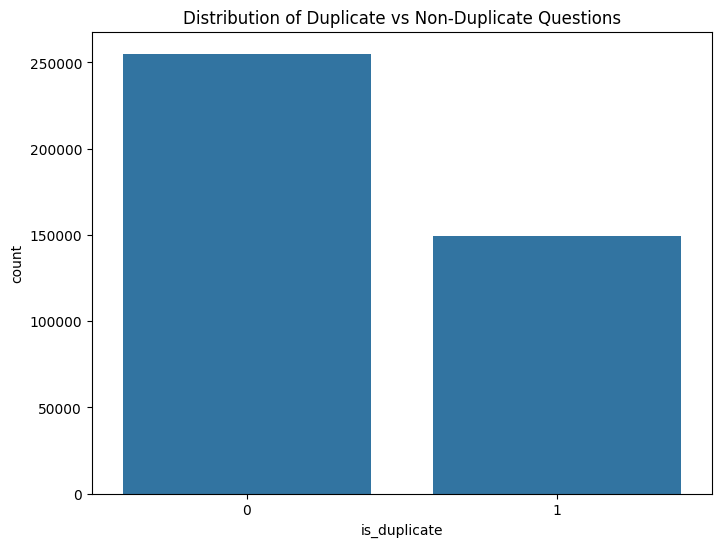

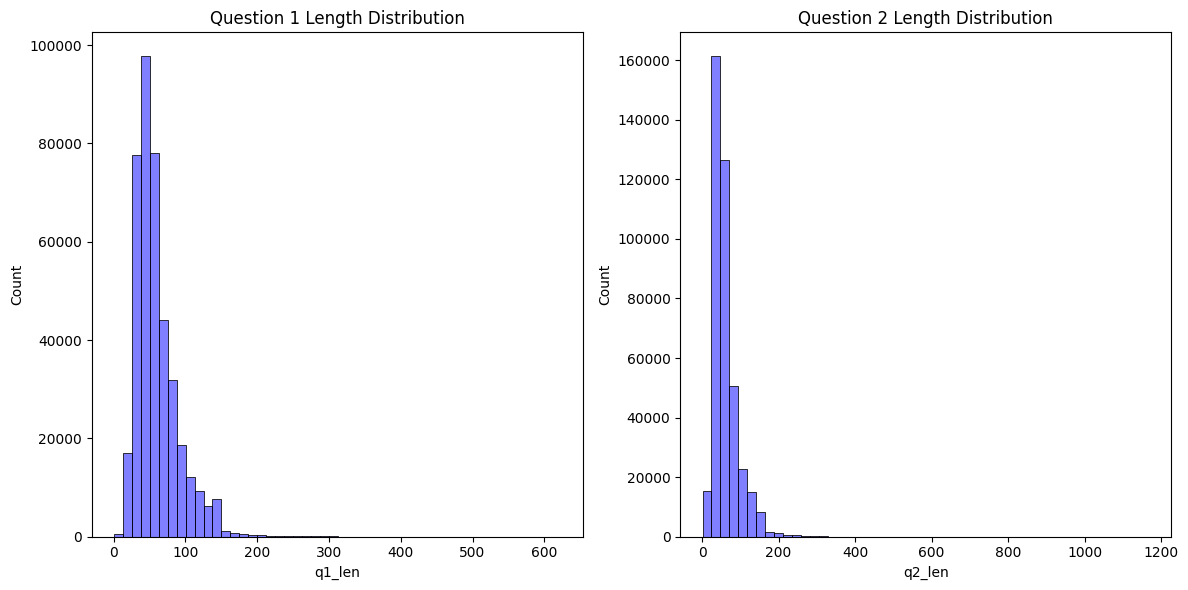

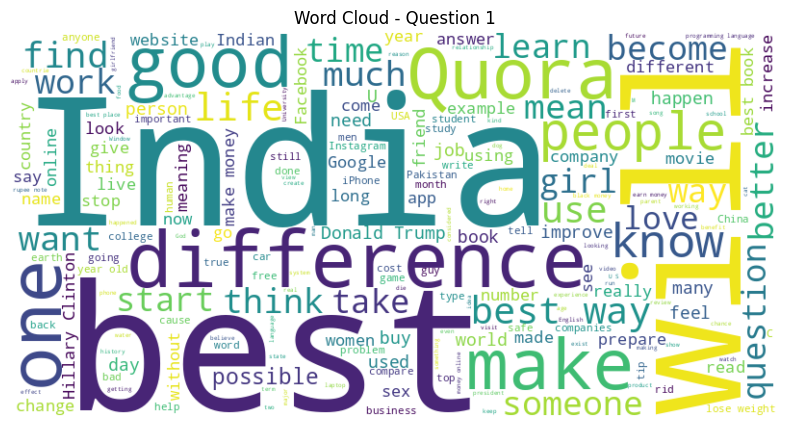

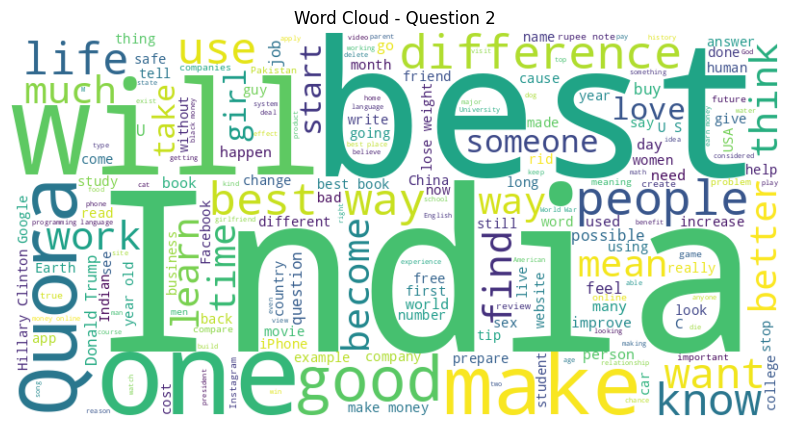


Basic statistics of question lengths:
              q1_len         q2_len
count  404289.000000  404288.000000
mean       59.536856      60.108663
std        29.940546      33.863690
min         1.000000       1.000000
25%        39.000000      39.000000
50%        52.000000      51.000000
75%        72.000000      72.000000
max       623.000000    1169.000000
EDA completed!


In [ ]:
from google.colab import drive
import pandas as pd

# Define file path (update this path if needed)
file_path = "/content/drive/My Drive/train.csv"

if __name__ == "__main__":
    # Load data
    print("Loading data...")
    train_df = pd.read_csv(file_path)

    # For EDA
    print("Running EDA...")
    train_df = perform_eda(train_df)
    print("EDA completed!")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading and preprocessing data...
Loading training data...
Training set size: 8000
Validation set size: 2000
Cleaning text...
Creating TF-IDF features...
Processing training data TF-IDF...
Processing validation data TF-IDF...
Combining features...
Creating sequence features...

Shape verification:
X_train_tfidf shape: (8000, 10000)
y_train shape: (8000,)
X_val_tfidf shape: (2000, 10000)
y_val shape: (2000,)

Training and evaluating models...

Training baseline models...
Creating baseline models...
Training Logistic Regression...
Training SVM...

Training Basic ANN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6458 - loss: 0.6410 - val_accuracy: 0.7010 - val_loss: 0.5888
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8069 - loss: 0.4185 - val_accuracy: 0.6930 - val_loss: 0.6530
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9093 - loss: 0.2356 - val_accuracy: 0.6705 - val_loss: 0.7710
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9583 - loss: 0.1153 - val_accuracy: 0.7000 - val_loss: 1.1592
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9769 - loss: 0.0618 - val_accuracy: 0.6950 - val_loss: 1.3766
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9906 - loss: 0.0295 - val_accuracy: 0.6835 - val_loss: 1.5643
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9934 - loss: 0.0188 - val_accuracy: 0.6925 - val_loss: 1.6416
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9951 - loss: 0.0143 - val_accuracy: 0.

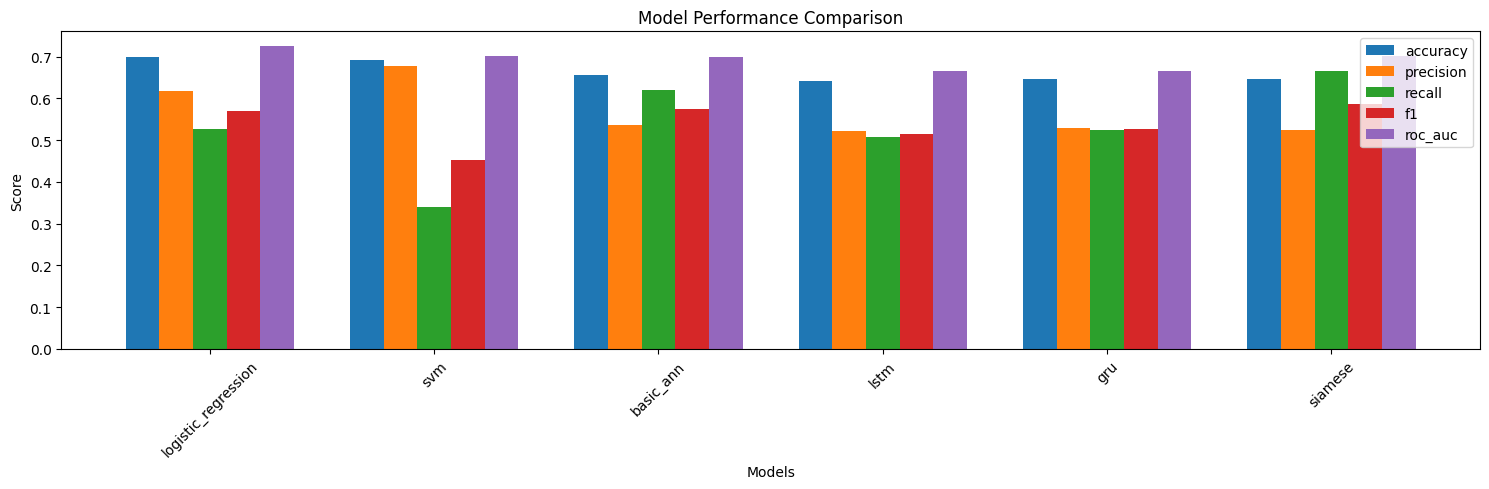

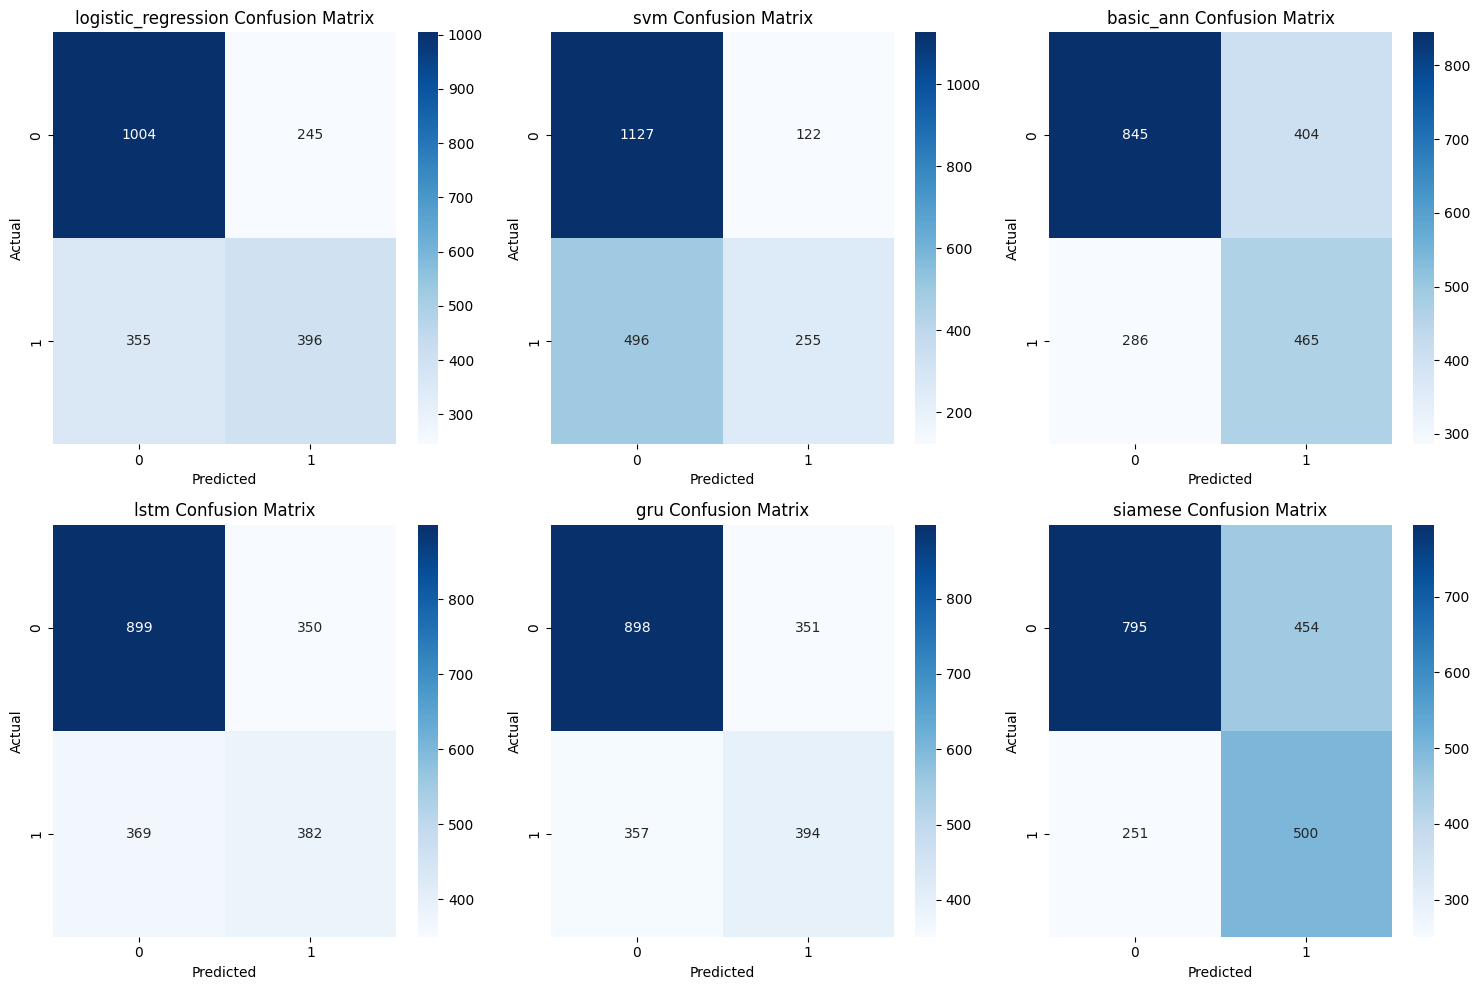

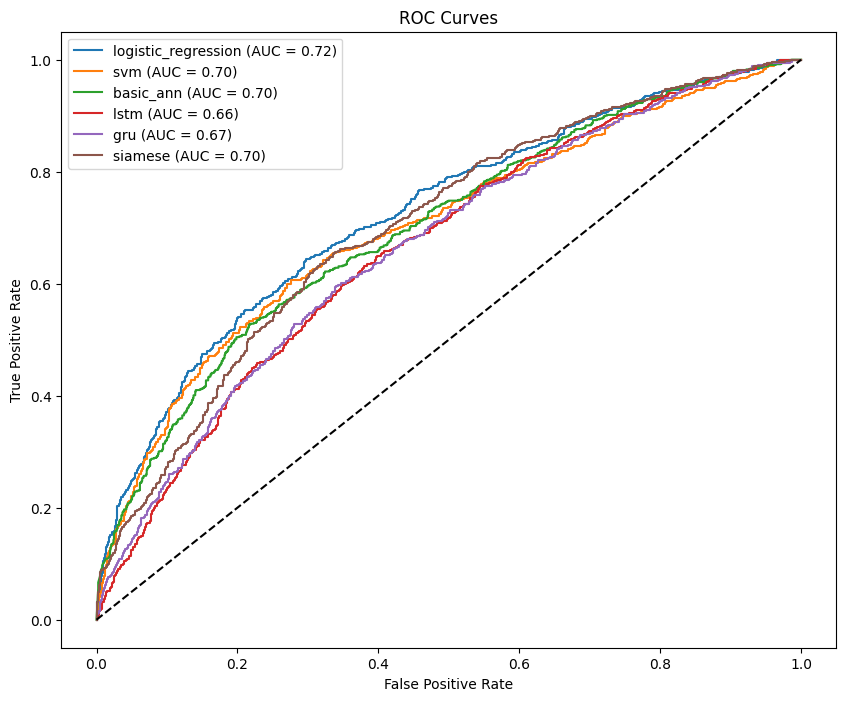

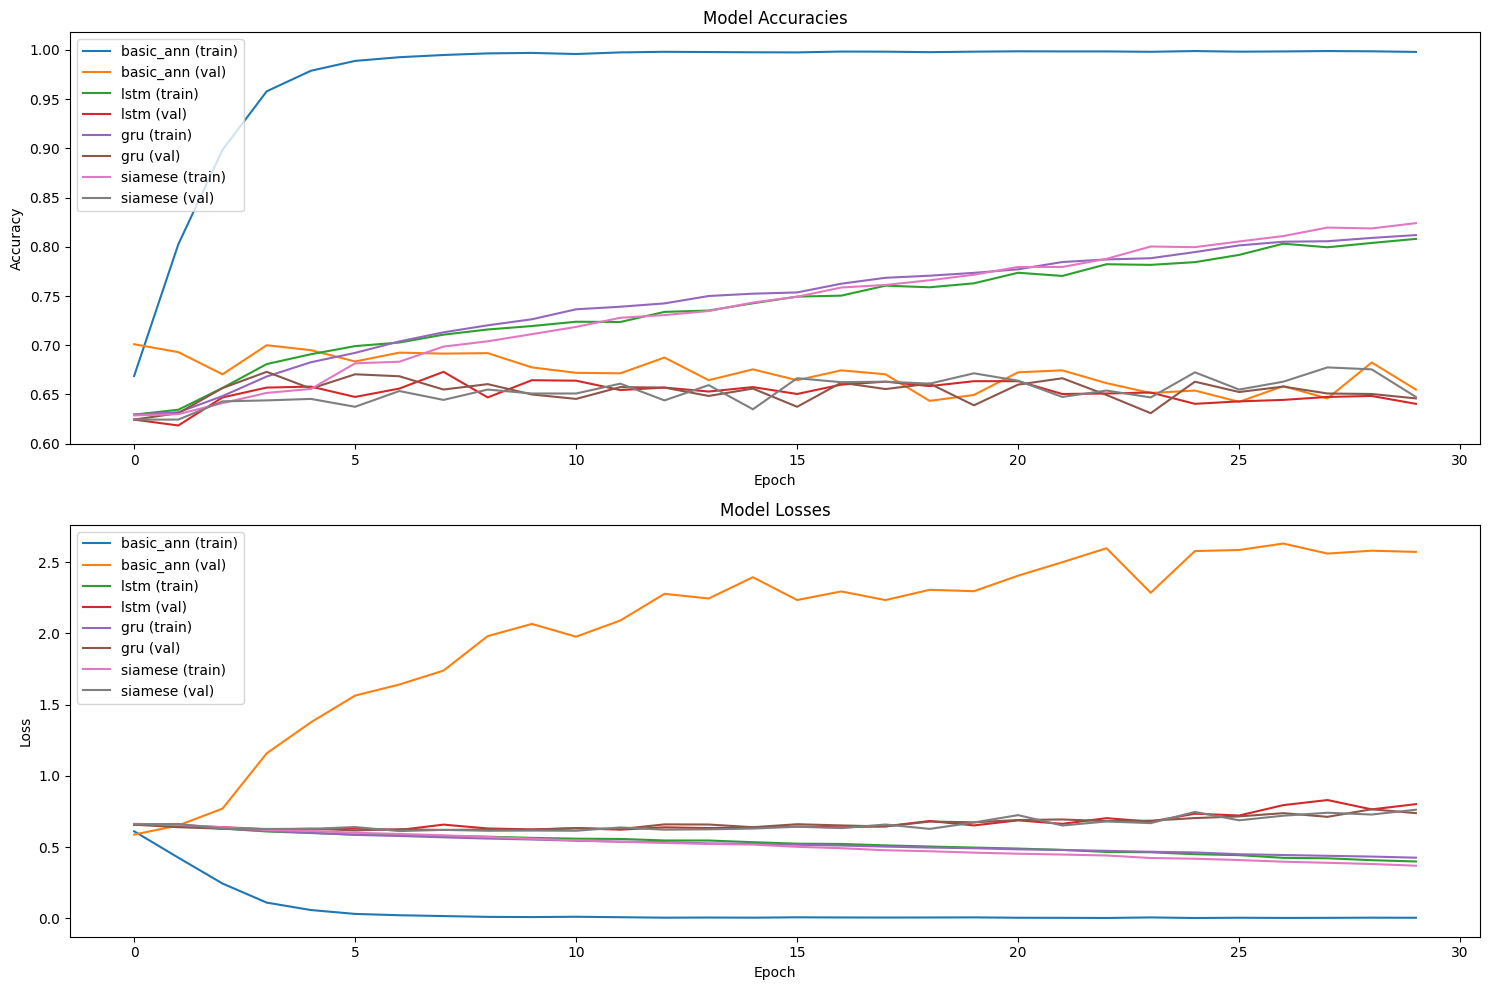


Detailed Evaluation Results:

logistic_regression:
accuracy: 0.7000
precision: 0.6178
recall: 0.5273
f1: 0.5690
roc_auc: 0.7243

svm:
accuracy: 0.6910
precision: 0.6764
recall: 0.3395
f1: 0.4521
roc_auc: 0.7008

basic_ann:
accuracy: 0.6550
precision: 0.5351
recall: 0.6192
f1: 0.5741
roc_auc: 0.6998

lstm:
accuracy: 0.6405
precision: 0.5219
recall: 0.5087
f1: 0.5152
roc_auc: 0.6647

gru:
accuracy: 0.6460
precision: 0.5289
recall: 0.5246
f1: 0.5267
roc_auc: 0.6656

siamese:
accuracy: 0.6475
precision: 0.5241
recall: 0.6658
f1: 0.5865
roc_auc: 0.7012


In [ ]:
# Main execution
if __name__ == "__main__":
    # Set parameters with smaller sample size for testing
    MAX_SEQUENCE_LENGTH = 50
    MAX_VOCAB_SIZE = 5000
    EMBEDDING_DIM = 100
    SAMPLE_SIZE = 10000  # Reduced sample size for testing

    try:
        # Mount Google Drive if in Colab
        from google.colab import drive
        drive.mount('/content/drive')
        file_path = "/content/drive/My Drive/train.csv"
    except:
        # If not in Colab, use local path
        file_path = "train.csv"

    print("Loading and preprocessing data...")
    # Preprocess data
    data = preprocess_data_for_all_models(
        max_sequence_length=MAX_SEQUENCE_LENGTH,
        max_vocab_size=MAX_VOCAB_SIZE,
        sample_size=SAMPLE_SIZE
    )

    print("\nTraining and evaluating models...")
    results, evaluation_results, model_tracker = train_and_evaluate_models(
        X_train=data['traditional']['X_train'],
        X_val=data['traditional']['X_val'],
        y_train=data['labels']['y_train'],
        y_val=data['labels']['y_val'],
        vocab_size=data['vocab_size'],
        max_sequence_length=MAX_SEQUENCE_LENGTH
    )

    # Plot training history
    plot_training_results(results)

    # Print detailed evaluation results
    print("\nDetailed Evaluation Results:")
    for model_name, metrics in evaluation_results.items():
        print(f"\n{model_name}:")
        for metric, value in metrics.items():
            if metric not in ['confusion_matrix', 'fpr', 'tpr']:
                print(f"{metric}: {value:.4f}")